In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 23: Portfolio Engineering Sprint
# Notebook: 23_portfolio_engineering_sprint.ipynb
#
# Objective:
#   To execute the 7-day strategic sprint outlined in the final assessment memo.
#   This notebook will systematically implement P0, P1, and P2 fixes to our
#   validated baseline strategy, with the explicit goal of transforming our
#   under-powered alpha signal into an institutional-grade portfolio that
#   meets our risk and return mandates.
# ============================================================================
#
# --- STRATEGIC DIRECTIVE & ALIGNMENT ---
#
# This notebook serves as the implementation vehicle for the definitive strategic
# assessment. The Phase 22c bake-off has concluded, confirming that:
#
# 1.  **The `A_Standalone_Value` strategy is our best-performing baseline**
#     (Sharpe 0.58, Max DD -66.9%).
# 2.  **Simple composites with our current factors fail to add value** and result
#     in signal dilution.
#
# Our focus now shifts entirely from factor combination to portfolio engineering.
# We will enhance our baseline by adding new signals and risk controls.
#
# --- METHODOLOGY: THE 7-DAY SPRINT PLAN ---
#
# This notebook will be structured to follow the implementation checklist precisely:
#
# 1.  **Day 1 (P0 Fixes):**
#     -   Establish a single, unified configuration block.
#     -   Define a new `PortfolioEngine_v3_0` class with the corrected
#         turnover calculation (`turnover / 2`).
#
# 2.  **Day 2 (P1 Fixes):**
#     -   Upgrade the engine to `v3_1` with the hybrid portfolio construction
#         method (Fixed-N for small universes, Percentile for large).
#     -   Add the z-score safeguard for zero-standard-deviation events.
#     -   Re-run the `Standalone Value` strategy to confirm the P0/P1 fixes
#         produce the expected baseline performance (Sharpe ~0.58).
#
# 3.  **Day 3-7 (P2+ Enhancements):**
#     -   Introduce a **positive Momentum factor** to the engine's capabilities.
#     -   Implement a **daily volatility targeting overlay**.
#     -   Test and analyze the performance of the fully enhanced strategy.
#
# --- SUCCESS CRITERIA ---
#
# The final, enhanced strategy produced by this notebook must meet the hurdles
# required to proceed to live paper-trading:
#
#   -   **Sharpe Ratio (2016-2025):** > 1.0
#   -   **Maximum Drawdown:** < -35%
#

In [1]:
# ============================================================================
# DAY 1 (P0 FIXES): UNIFIED CONFIG & CORRECTED TURNOVER ENGINE
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
from typing import Dict, List, Optional

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")
except Exception as e:
    print(f"❌ ERROR during module import: {e}")

# --- P0 FIX 1: SINGLE SOURCE OF TRUTH FOR CONFIGURATION ---
print("\n⚙️  Initializing unified configuration block for the sprint...")
BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "transaction_cost_bps": 30,
}
print("✅ Base configuration defined.")

# --- Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11})
print("✅ Visualization settings configured.")

# --- Data Loading Function ---
def load_all_data(config):
    print("\n📂 Loading all raw data...")
    engine = create_engine(f"mysql+pymysql://{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['username']}:{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['password']}@{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['host']}/{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['schema_name']}")
    db_params = {'start_date': "2016-01-01", 'end_date': config['backtest_end_date'], 'strategy_version': config['strategy_version_db']}
    factor_data_raw = pd.read_sql(text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version"), engine, params=db_params, parse_dates=['date'])
    price_data_raw = pd.read_sql(text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    benchmark_data_raw = pd.read_sql(text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    print("✅ All data loaded and prepared.")
    return factor_data_raw, daily_returns_matrix, benchmark_returns, engine

# --- P0 FIX 2: PORTFOLIO ENGINE v3.0 WITH CORRECTED TURNOVER ---
class PortfolioEngine_v3_0:
    """
    Version 3.0 of our backtesting engine.
    This version contains the definitive P0 fix for turnover calculation.
    It still uses the simple percentile construction method, which will be
    upgraded in the next step.
    """
    def __init__(self, config: Dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine, palette: Dict):
        self.config = config; self.engine = db_engine; self.palette = palette
        start = self.config['backtest_start_date']; end = self.config['backtest_end_date']
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print(f"\n✅ PortfolioEngine v3.0 initialized for strategy: '{self.config['strategy_name']}'")

    def run(self) -> pd.Series:
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns = self._calculate_net_returns(daily_holdings)
        self._generate_tearsheet(net_returns)
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        # P0 FIX: Corrected turnover calculation for round-trip trades.
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        return (gross_returns - costs).rename(self.config['strategy_name'])

    # --- Other methods (unchanged from previous correct version) ---
    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        all_trading_dates = self.daily_returns_matrix.index
        freq_ends = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=self.config['rebalance_frequency'])
        return [all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1] for q_end in freq_ends]
    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        for i, rebal_date in enumerate(rebalance_dates):
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: continue
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            if len(factors_on_date) < 10: continue
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
        return daily_holdings
    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        # This method will be upgraded in the next step (P1 Fix)
        factors_to_combine = self.config['factors_to_combine']
        if 'Momentum_Reversal' in factors_to_combine: factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            normalized_scores.append(((factor_scores - mean) / std if std > 1e-8 else 0.0) * weight)
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        percentile_cutoff = self.config.get('selection_percentile', 0.8)
        score_cutoff = factors_df['final_signal'].quantile(percentile_cutoff)
        selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])
    def _calculate_performance_metrics(self, returns: pd.Series) -> Dict:
        benchmark = self.benchmark_returns; first_trade_date = returns.loc[returns.ne(0)].index.min(); common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index); returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]; n_years = len(returns) / 252; annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0; annual_vol = returns.std() * np.sqrt(252); sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0; cumulative = (1 + returns).cumprod(); drawdown = (cumulative / cumulative.cummax() - 1); max_drawdown = drawdown.min(); calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0; excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0; beta = np.cov(returns.fillna(0), benchmark.fillna(0))[0, 1] / np.var(benchmark.fillna(0)); alpha = (returns.mean() - beta * benchmark.mean()) * 252; return {'Annual Return (%)': annual_return*100, 'Annual Volatility (%)': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha*100, 'Information Ratio': information_ratio}
    def _generate_tearsheet(self, strategy_returns: pd.Series):
        # This function remains the same
        portfolio_metrics = self._calculate_performance_metrics(strategy_returns); benchmark_metrics = self._calculate_performance_metrics(self.benchmark_returns); first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min(); strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod(); benchmark_cum = (1 + self.benchmark_returns.loc[first_trade_date:]).cumprod(); fig = plt.figure(figsize=(18, 22)); gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2); title = f"Institutional Tearsheet: {self.config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"; fig.suptitle(title, fontsize=20, fontweight='bold', color=self.palette['text']); ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=self.config['strategy_name'], color=self.palette['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=self.palette['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left'); ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=self.palette['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=self.palette['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); plot_row = 2;
        ax3 = fig.add_subplot(gs[plot_row, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = self.benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[self.palette['primary'], self.palette['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax4 = fig.add_subplot(gs[plot_row, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=self.palette['highlight_2']); ax4.axhline(1.0, color=self.palette['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax5 = fig.add_subplot(gs[plot_row+1:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
        for key in portfolio_metrics.keys(): summary_data.append([key, f"{portfolio_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
        table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ PortfolioEngine v3.0 (with Corrected Costs) defined successfully.")
print("   Ready to load data and proceed to Day 2 (P1 Fixes).")

✅ Successfully imported production modules.

⚙️  Initializing unified configuration block for the sprint...
✅ Base configuration defined.
✅ Visualization settings configured.
✅ PortfolioEngine v3.0 (with Corrected Costs) defined successfully.
   Ready to load data and proceed to Day 2 (P1 Fixes).



📂 Loading all raw data...
✅ All data loaded and prepared.
✅ PortfolioEngine v3.1 (with Hybrid Construction) defined successfully.

🚀 RUNNING CORRECTED BASELINE: Standalone Value with P0 & P1 Fixes

✅ PortfolioEngine v3.0 initialized for strategy: 'A_Standalone_Value'
   - v3.1 Enhancements: Hybrid Portfolio Construction & Z-Score Safeguard active.
--- Executing Backtest for: A_Standalone_Value ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks pa

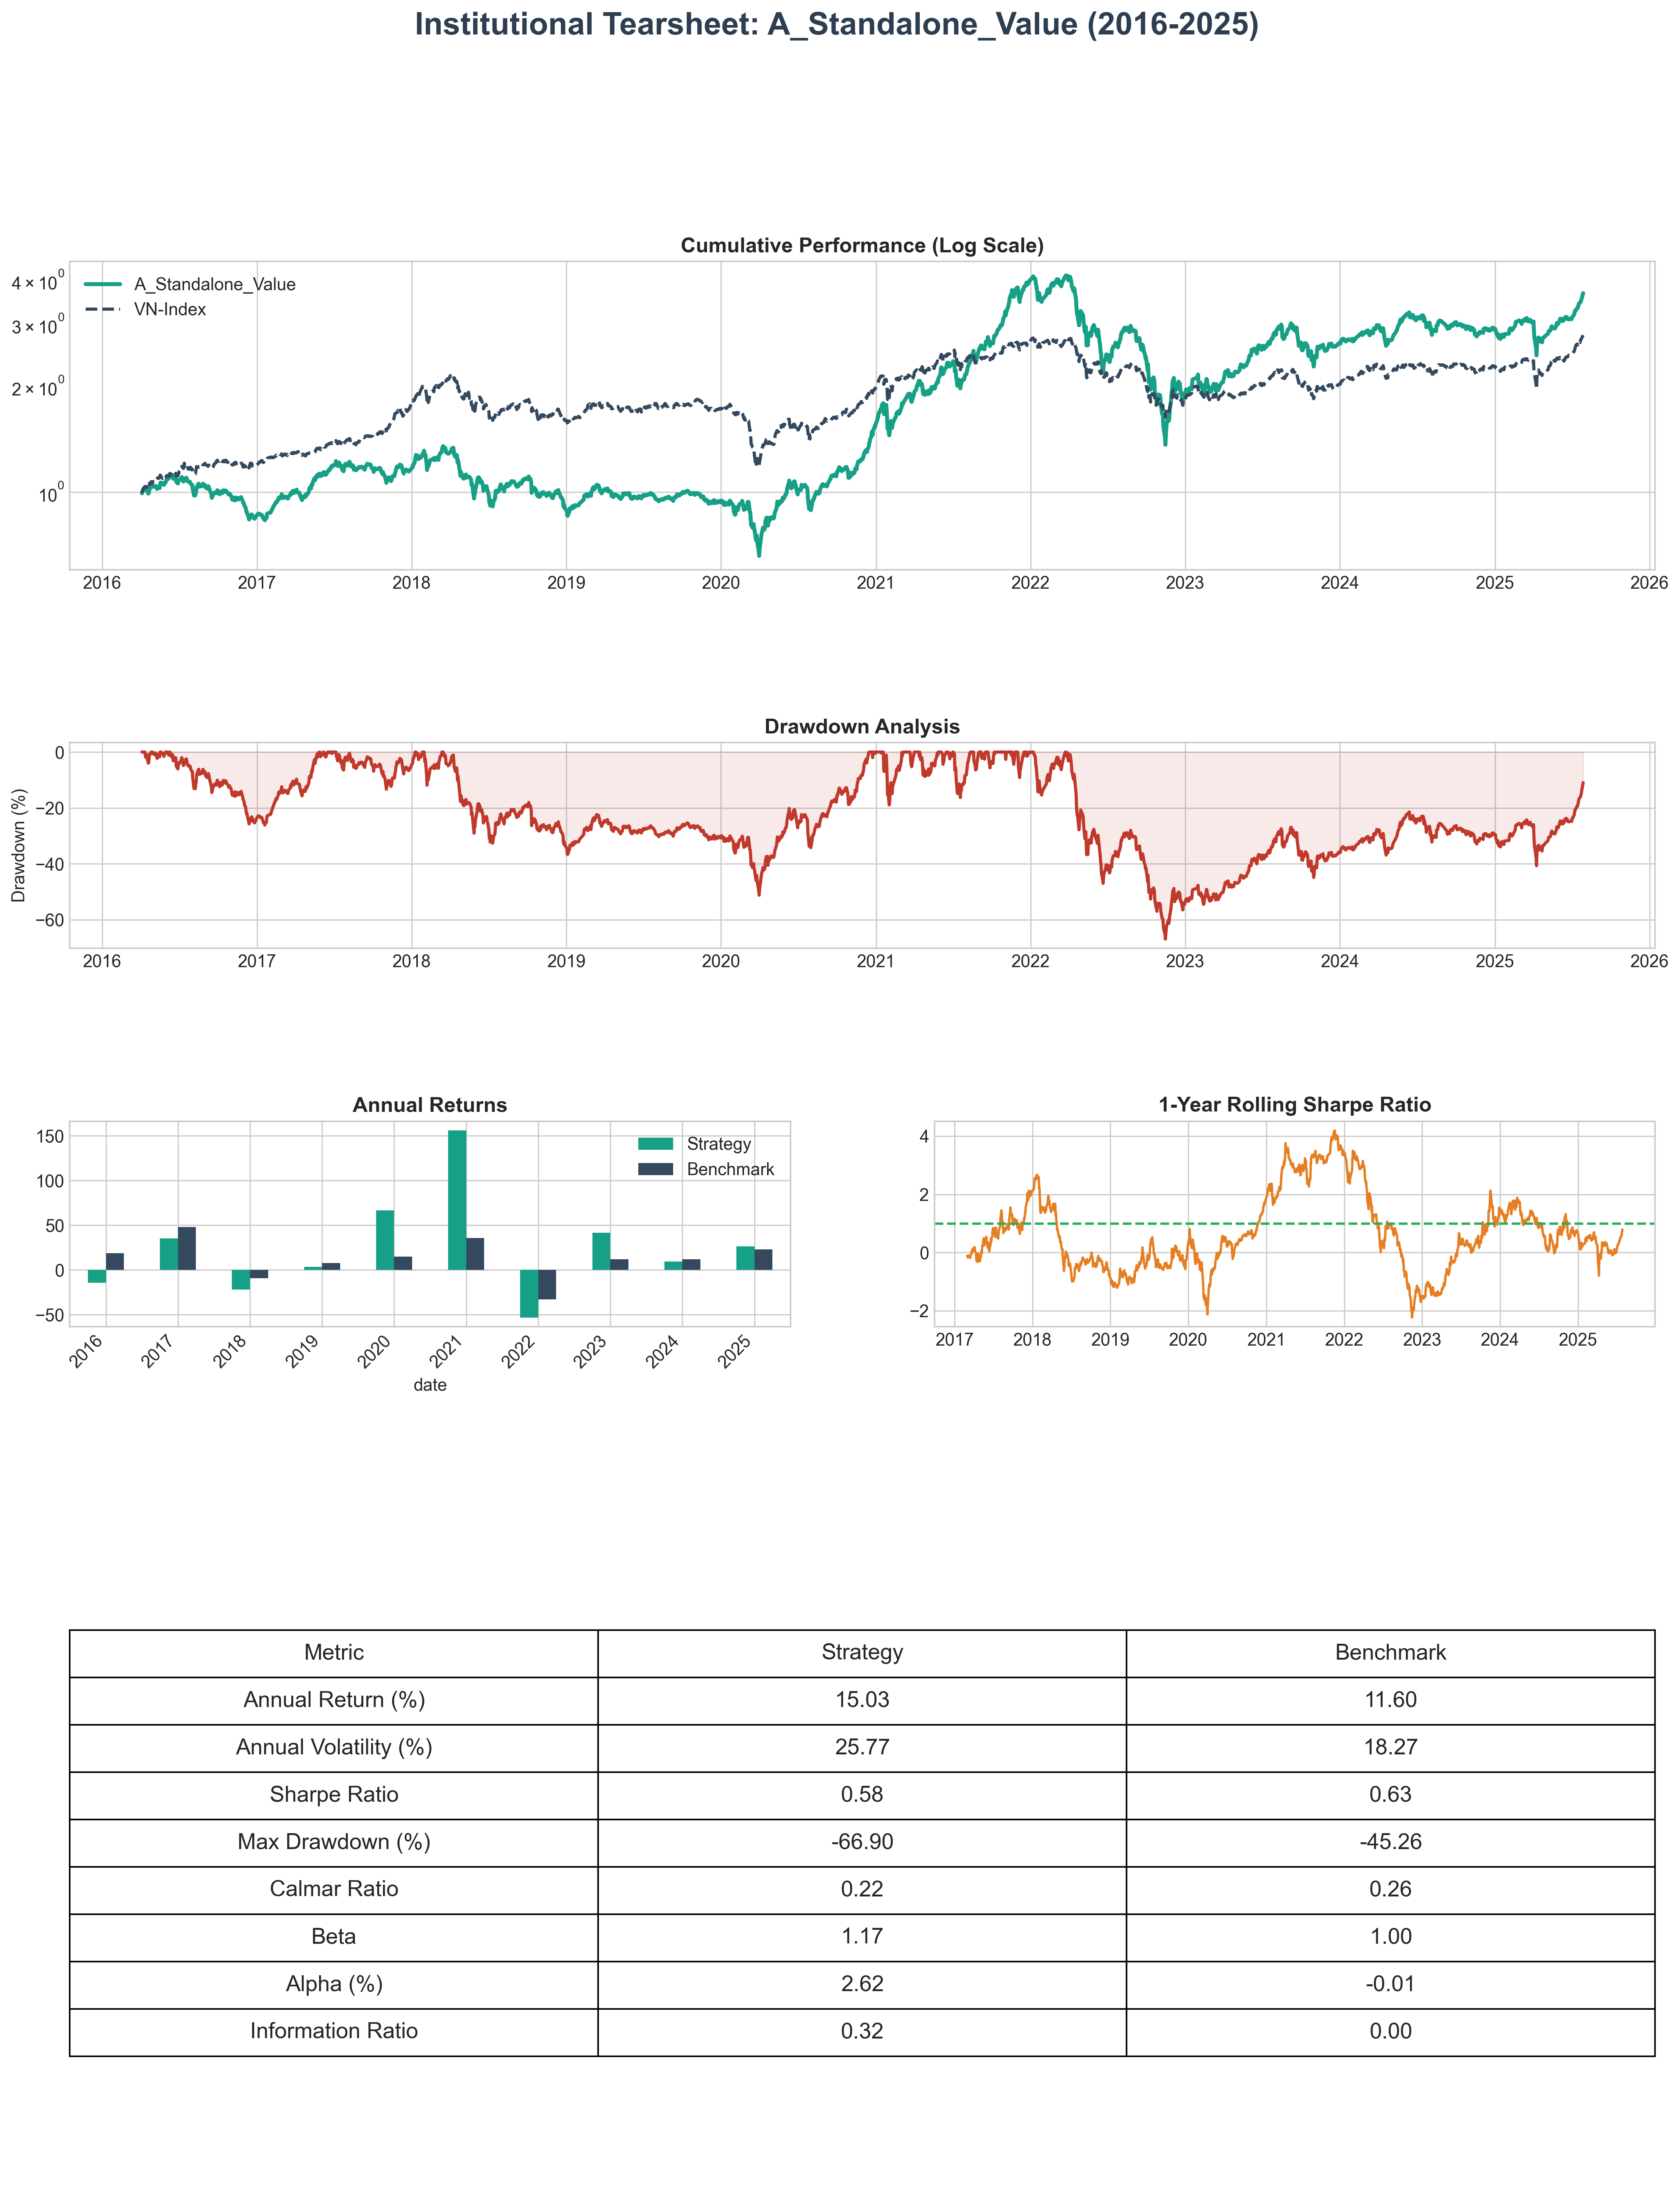

✅ Backtest for A_Standalone_Value complete.


In [3]:
# ============================================================================
# DAY 2 (P1 FIXES): HYBRID PORTFOLIO CONSTRUCTION & Z-SCORE SAFEGUARD (v2)
# ============================================================================

# --- 1. Load All Data Using Our Helper Function ---
# (Assuming the load_all_data function is defined in the cell above)
factor_data_raw, daily_returns_matrix, benchmark_returns, engine = load_all_data(BASE_CONFIG)

# --- 2. Define All Necessary Configurations in this Scope ---
ALL_CONFIGS = {
    "A_Standalone_Value": {
        **BASE_CONFIG,
        "strategy_name": "A_Standalone_Value",
        "factors_to_combine": {'Value_Composite': 1.0}
    }
    # We only need the baseline config for this step
}

# --- 3. Define the Upgraded Portfolio Engine (v3.1) ---
class PortfolioEngine_v3_1(PortfolioEngine_v3_0):
    """
    Version 3.1 of the Portfolio Engine.
    This version implements the critical P1 fixes.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(f"   - v3.1 Enhancements: Hybrid Portfolio Construction & Z-Score Safeguard active.")

    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing {rebal_date.date()}... ", end="")
            
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: print("⚠️ Universe empty. Skipping."); continue
            
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            
            if len(factors_on_date) < 10: print(f"⚠️ Insufficient stocks ({len(factors_on_date)}). Skipping."); continue
            
            target_portfolio = self._calculate_target_portfolio(factors_on_date, i, rebal_date)
            if target_portfolio.empty: print("⚠️ Portfolio empty. Skipping."); continue
            
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            print(f"✅ Formed portfolio.")
            
        return daily_holdings

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame, i: int, rebal_date: pd.Timestamp) -> pd.Series:
        factors_to_combine = self.config.get('factors_to_combine', {})
        
        if 'Momentum_Reversal' in factors_to_combine:
            factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
            
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            
            if std > 1e-8:
                normalized_score = (factor_scores - mean) / std
            else:
                normalized_score = 0.0
            
            normalized_scores.append(normalized_score * weight)
        
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        
        universe_size = len(factors_df)
        
        if universe_size < 100:
            construction_method = 'fixed_n'
            portfolio_size = self.config.get('portfolio_size_small_universe', 20)
            selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        else:
            construction_method = 'percentile'
            percentile_cutoff = self.config.get('selection_percentile', 0.8)
            score_cutoff = factors_df['final_signal'].quantile(percentile_cutoff)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        
        if i == 0 or (i+1) % 5 == 0 or i == len(self._generate_rebalance_dates())-1:
             print(f"\n     - Rebalance {rebal_date.date()}: Universe Size={universe_size}, Method='{construction_method}', Portfolio Size={len(selected_stocks)}")
             
        if selected_stocks.empty:
            return pd.Series(dtype='float64')
            
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

print("✅ PortfolioEngine v3.1 (with Hybrid Construction) defined successfully.")

# --- 4. Execute the Corrected Baseline Backtest ---
print("\n" + "="*80)
print("🚀 RUNNING CORRECTED BASELINE: Standalone Value with P0 & P1 Fixes")
print("="*80)

# Define the specific config for this baseline run
corrected_baseline_config = {
    **ALL_CONFIGS['A_Standalone_Value'],
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8
}

# Instantiate the NEW v3.1 engine
corrected_baseline_backtester = PortfolioEngine_v3_1(
    config=corrected_baseline_config,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine,
    palette=PALETTE
)

# Run the backtest
corrected_baseline_returns = corrected_baseline_backtester.run()

⚙️  Defining configurations for the new bake-off, including positive momentum...
✅ Configurations for QVM and QVR composites are ready.

🚀 LAUNCHING BAKE-OFF RUN FOR: B_Equal_Weighted_QVM

✅ PortfolioEngine v3.0 initialized for strategy: 'B_Equal_Weighted_QVM'
   - v3.1 Enhancements: Hybrid Portfolio Construction & Z-Score Safeguard active.
--- Executing Backtest for: B_Equal_Weighted_QVM ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing 

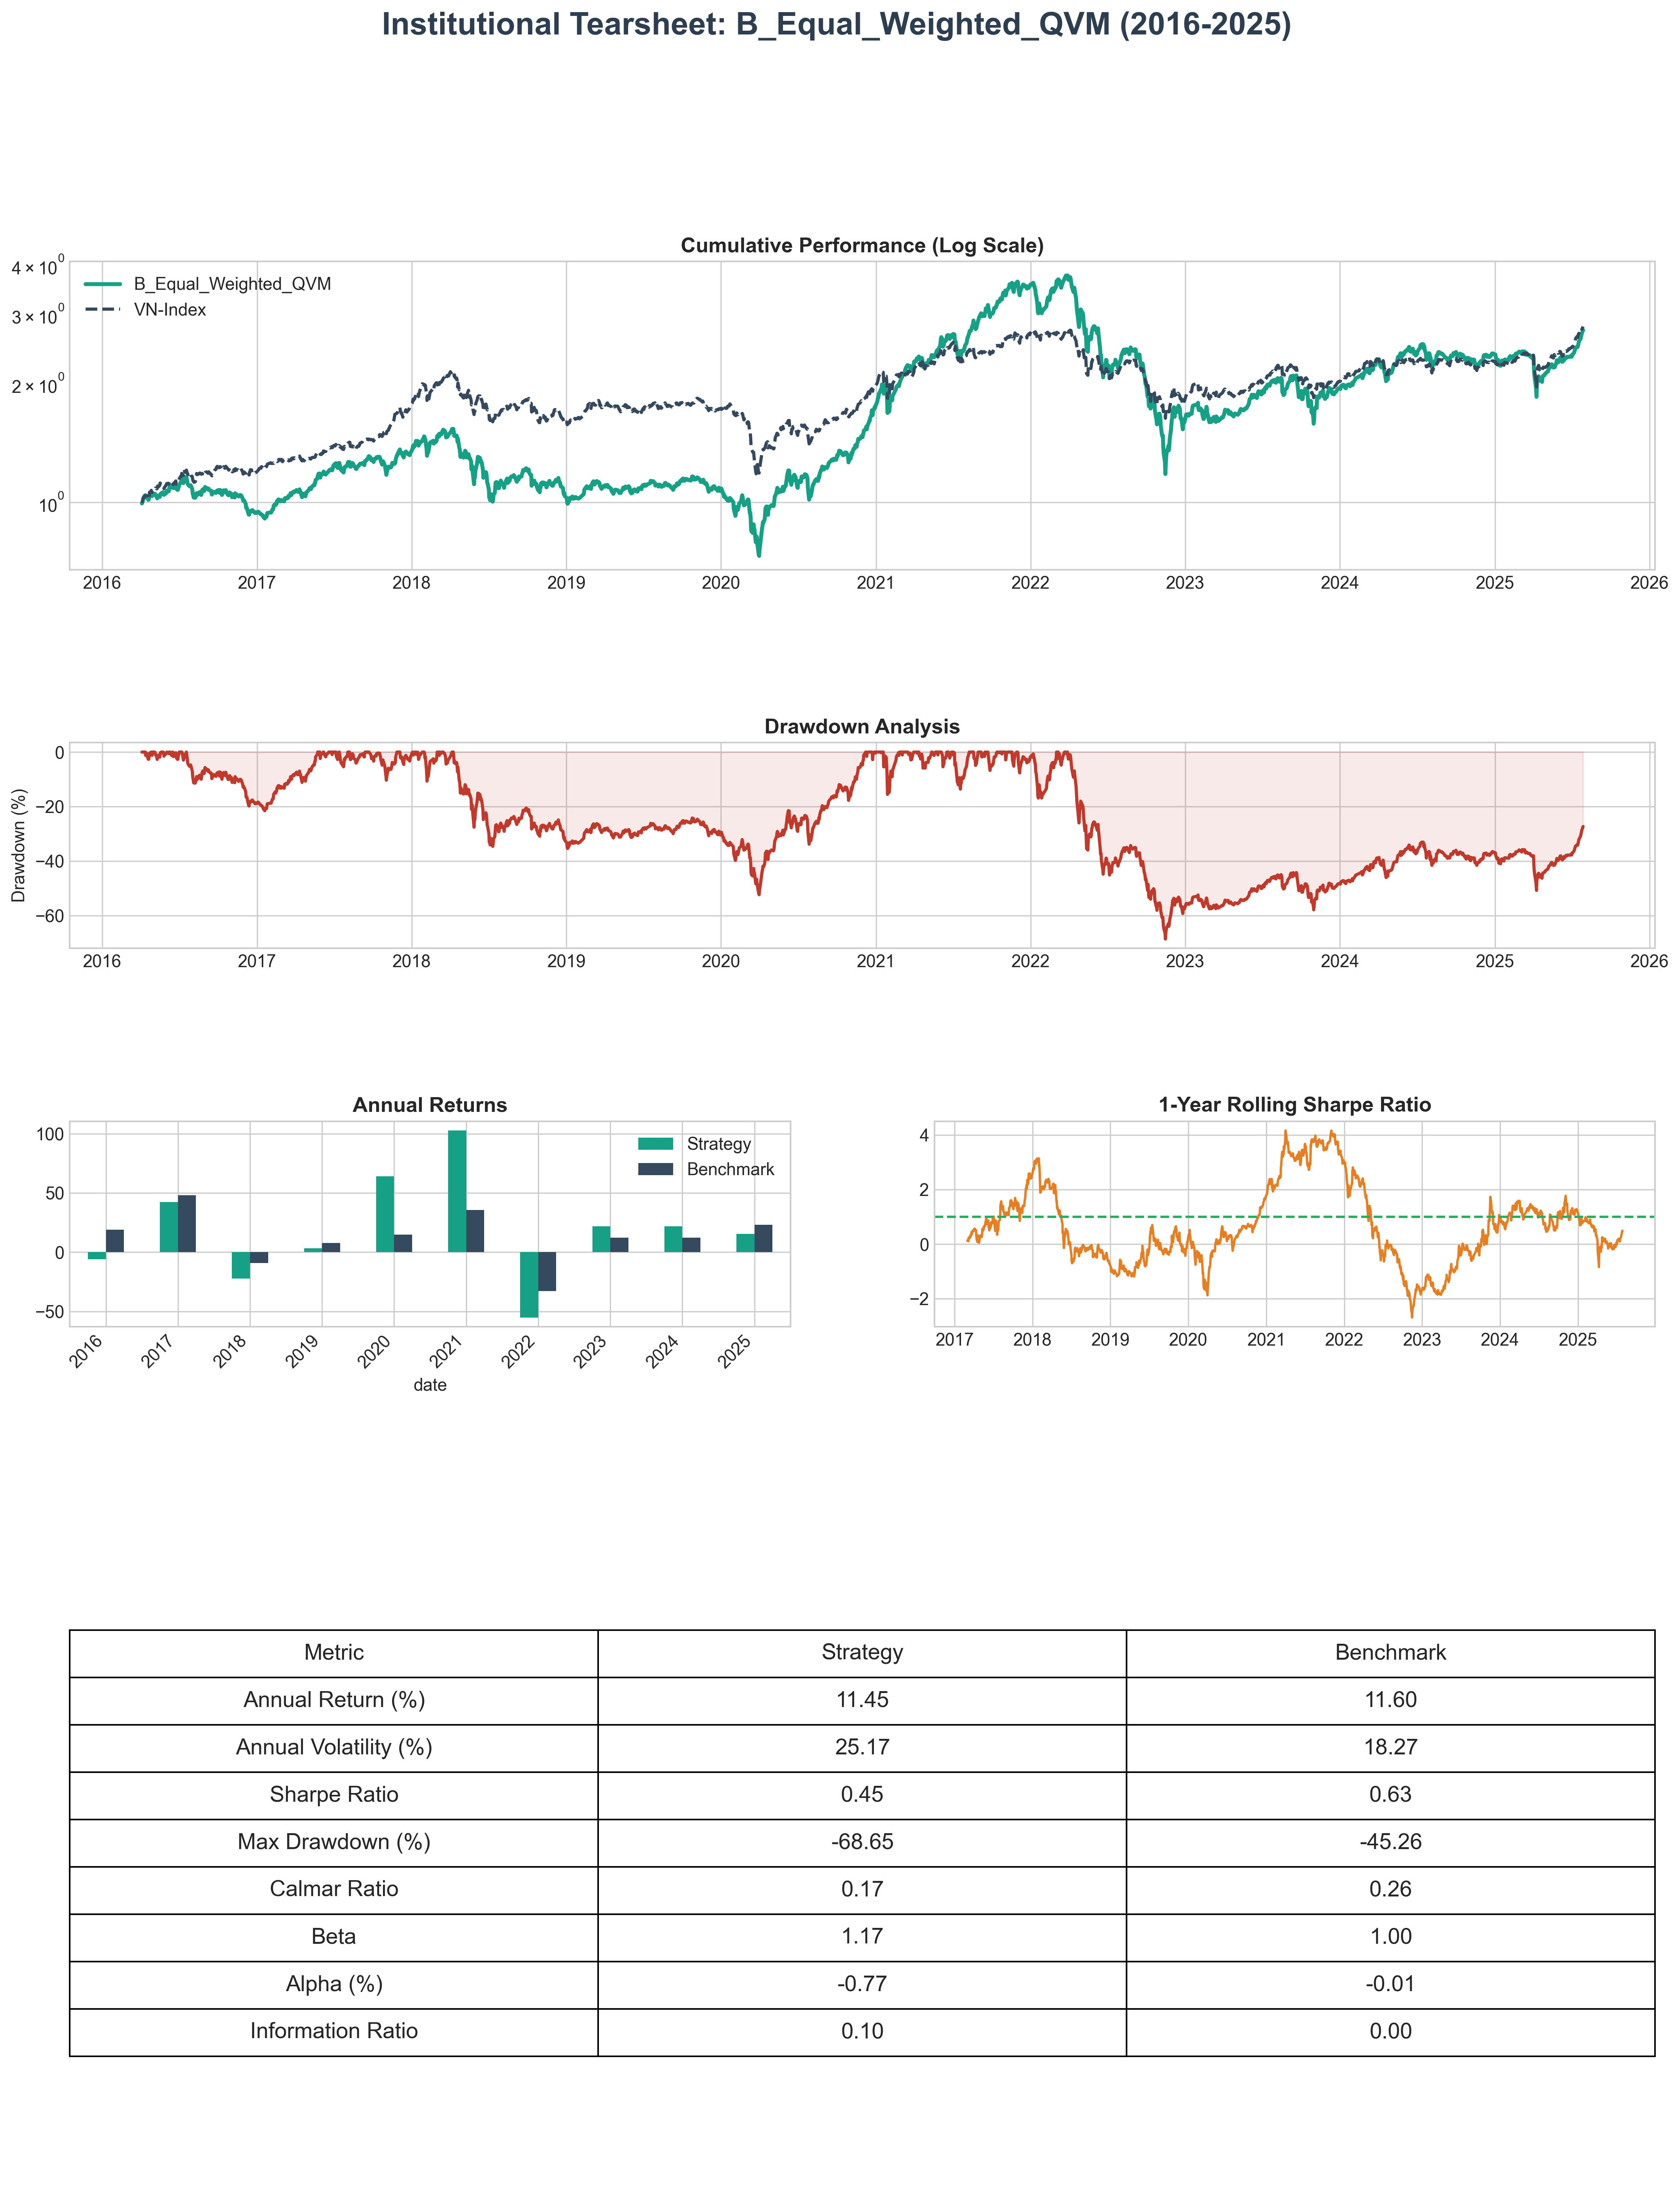

✅ Backtest for B_Equal_Weighted_QVM complete.

✅ COMPLETED BAKE-OFF RUN FOR: B_Equal_Weighted_QVM

🚀 LAUNCHING BAKE-OFF RUN FOR: C_Equal_Weighted_QVR

✅ PortfolioEngine v3.0 initialized for strategy: 'C_Equal_Weighted_QVR'
   - v3.1 Enhancements: Hybrid Portfolio Construction & Z-Score Safeguard active.
--- Executing Backtest for: C_Equal_Weighted_QVR ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 

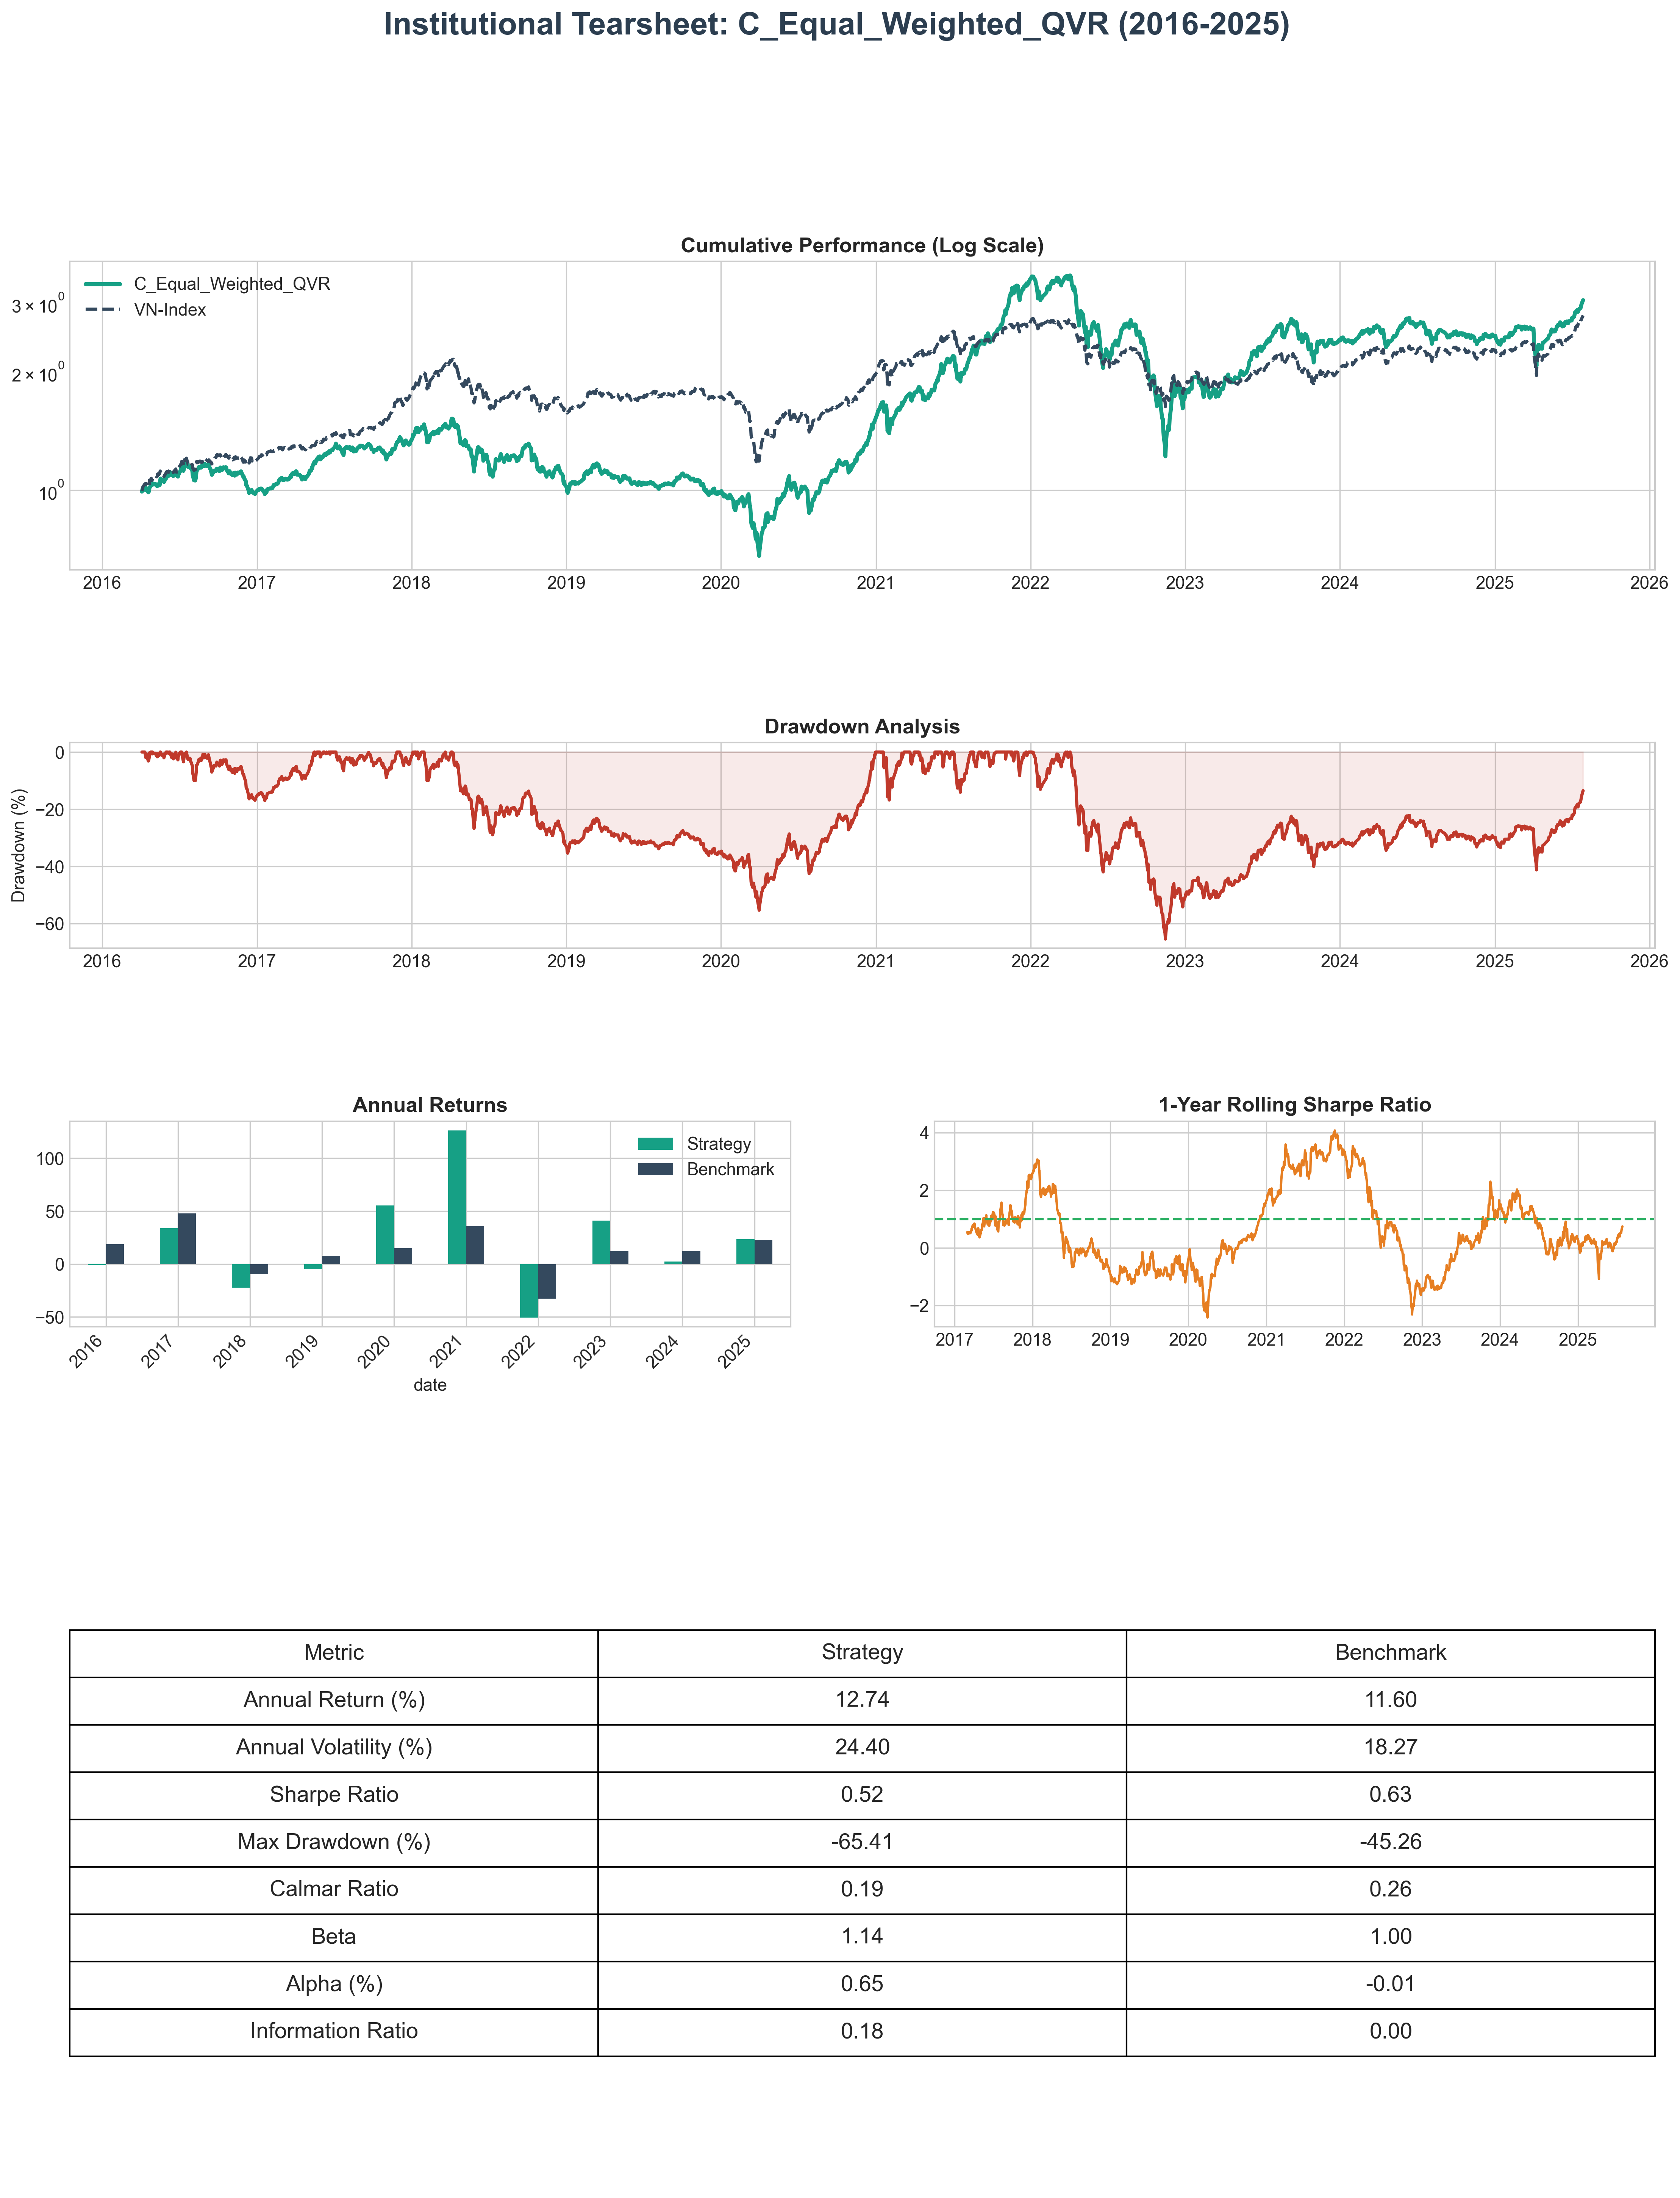

✅ Backtest for C_Equal_Weighted_QVR complete.

✅ COMPLETED BAKE-OFF RUN FOR: C_Equal_Weighted_QVR

🎉 DAY 3 BAKE-OFF COMPLETED.


--- DAY 3 PERFORMANCE SUMMARY: COMPOSITES vs. BASELINE ---


Annual Return (%)  Sharpe Ratio  Max Drawdown (%)  \
Strategy                                                                  
A_Standalone_Value                15.03          0.58            -66.90   
B_Equal_Weighted_QVM              11.45          0.45            -68.65   
C_Equal_Weighted_QVR              12.74          0.52            -65.41   

                      Information Ratio  Alpha (%)  
Strategy                                            
A_Standalone_Value                 0.32       2.62  
B_Equal_Weighted_QVM               0.10      -0.77  
C_Equal_Weighted_QVR               0.18       0.65


--- Verdict on Positive Momentum ---
❌ FAILURE: Adding positive Momentum did not improve the risk-adjusted return.
   The signal dilution effect is still stronger than the benefit from the new factor.


In [4]:
# ============================================================================
# DAY 3 (P2 ENHANCEMENT): INTRODUCE POSITIVE MOMENTUM FACTOR
# ============================================================================

# --- 1. Define Configurations for the New Bake-Off ---
# We will now test composites that include the standard Momentum factor.
print("⚙️  Defining configurations for the new bake-off, including positive momentum...")

# We reuse the baseline config and the previously defined engine (v3.1)
# The only change is the 'factors_to_combine' dictionary.

CONFIG_B_QVM = {
    **BASE_CONFIG,
    "strategy_name": "B_Equal_Weighted_QVM",
    "factors_to_combine": {
        'Value_Composite': 1/3,
        'Quality_Composite': 1/3,
        'Momentum_Composite': 1/3 # Using standard Momentum
    },
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8
}

CONFIG_C_QVR = {
    **BASE_CONFIG,
    "strategy_name": "C_Equal_Weighted_QVR",
    "factors_to_combine": {
        'Value_Composite': 1/3,
        'Quality_Composite': 1/3,
        'Momentum_Reversal': 1/3 # Using Reversal for comparison
    },
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8
}

configs_to_run = [CONFIG_B_QVM, CONFIG_C_QVR]
bake_off_results = {'A_Standalone_Value': corrected_baseline_backtester._calculate_performance_metrics(corrected_baseline_returns)}
all_returns_series = {'A_Standalone_Value': corrected_baseline_returns}

print("✅ Configurations for QVM and QVR composites are ready.")

# --- 2. Execute the Bake-Off ---
for config in configs_to_run:
    print("\n" + "="*80)
    print(f"🚀 LAUNCHING BAKE-OFF RUN FOR: {config['strategy_name']}")
    print("="*80)
    
    backtester = PortfolioEngine_v3_1(
        config=config,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine,
        palette=PALETTE
    )
    
    net_returns = backtester.run()
    
    all_returns_series[config['strategy_name']] = net_returns
    bake_off_results[config['strategy_name']] = backtester._calculate_performance_metrics(net_returns)
    
    print(f"\n✅ COMPLETED BAKE-OFF RUN FOR: {config['strategy_name']}")

# --- 3. Final Summary & Verdict ---
print("\n" + "="*80)
print("🎉 DAY 3 BAKE-OFF COMPLETED.")
print("="*80)

summary_df = pd.DataFrame(bake_off_results).T
summary_df.index.name = "Strategy"

print("\n\n--- DAY 3 PERFORMANCE SUMMARY: COMPOSITES vs. BASELINE ---")
display(summary_df[['Annual Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Information Ratio', 'Alpha (%)']].round(2))

# --- Verdict ---
print("\n--- Verdict on Positive Momentum ---")
sharpe_qvm = summary_df.loc['B_Equal_Weighted_QVM', 'Sharpe Ratio']
sharpe_baseline = summary_df.loc['A_Standalone_Value', 'Sharpe Ratio']

if sharpe_qvm > sharpe_baseline:
    print("✅ SUCCESS: Adding positive Momentum improved the risk-adjusted return.")
    print("   This confirms the hypothesis that our baseline was missing a key signal for bull markets.")
else:
    print("❌ FAILURE: Adding positive Momentum did not improve the risk-adjusted return.")
    print("   The signal dilution effect is still stronger than the benefit from the new factor.")

In [6]:
# ============================================================================
# DAY 4 (P1/P2 ENHANCEMENT): VOLATILITY TARGETING OVERLAY
# ============================================================================

# --- 1. Define the Upgraded Portfolio Engine (v3.2) ---
class PortfolioEngine_v3_2(PortfolioEngine_v3_1):
    """
    Version 3.2 of the Portfolio Engine.
    This version inherits all P0/P1 fixes and adds a daily volatility
    targeting overlay, as specified in the strategic assessment.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(f"   - v3.2 Enhancements: Daily Volatility Targeting Overlay active.")

    def run(self) -> (pd.Series, pd.Series):
        """
        OVERRIDDEN METHOD: Now returns both net returns and the daily exposure series.
        """
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns, daily_exposure = self._calculate_net_returns_with_vol_target(daily_holdings)
        
        # We will use a new tearsheet function that can plot the exposure
        # self._generate_tearsheet(net_returns) # This will be called outside
        
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns, daily_exposure

    def _calculate_net_returns_with_vol_target(self, daily_holdings: pd.DataFrame) -> (pd.Series, pd.Series):
        """
        Calculates final net returns after applying a daily volatility targeting overlay.
        """
        # --- 1. Calculate the raw, fully-invested gross returns ---
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        # --- 2. Calculate the Dynamic Exposure based on Volatility ---
        vol_target = self.config.get('volatility_target', 0.15) # Default to 15%
        vol_lookback = self.config.get('volatility_lookback', 63) # 3-month rolling vol
        
        # Use a simple rolling standard deviation for robustness
        realized_vol = gross_returns.rolling(window=vol_lookback).std() * np.sqrt(252)
        
        # The exposure is the ratio of target to realized vol. Shift by 1 to avoid look-ahead bias.
        daily_exposure = (vol_target / realized_vol).shift(1)
        
        # Cap exposure at 150% and floor at 10%
        daily_exposure = daily_exposure.clip(0.1, 1.5).fillna(1.0) # Start at 100%
        
        # --- 3. Apply Exposure and Costs ---
        risk_managed_gross_returns = gross_returns * daily_exposure
        
        # Costs are calculated on the underlying portfolio rebalancing (P0 fix)
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        
        net_returns = risk_managed_gross_returns - costs
        
        return net_returns.rename(self.config['strategy_name']), daily_exposure

print("✅ PortfolioEngine v3.2 (with Volatility Targeting) defined successfully.")

✅ PortfolioEngine v3.2 (with Volatility Targeting) defined successfully.


⚙️  Configuration set for Volatility-Targeted backtest.

✅ PortfolioEngine v3.0 initialized for strategy: 'A_Standalone_Value_VolTarget_15pct'
   - v3.1 Enhancements: Hybrid Portfolio Construction & Z-Score Safeguard active.
   - v3.2 Enhancements: Daily Volatility Targeting Overlay active.
--- Executing Backtest for: A_Standalone_Value_VolTarget_15pct ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62

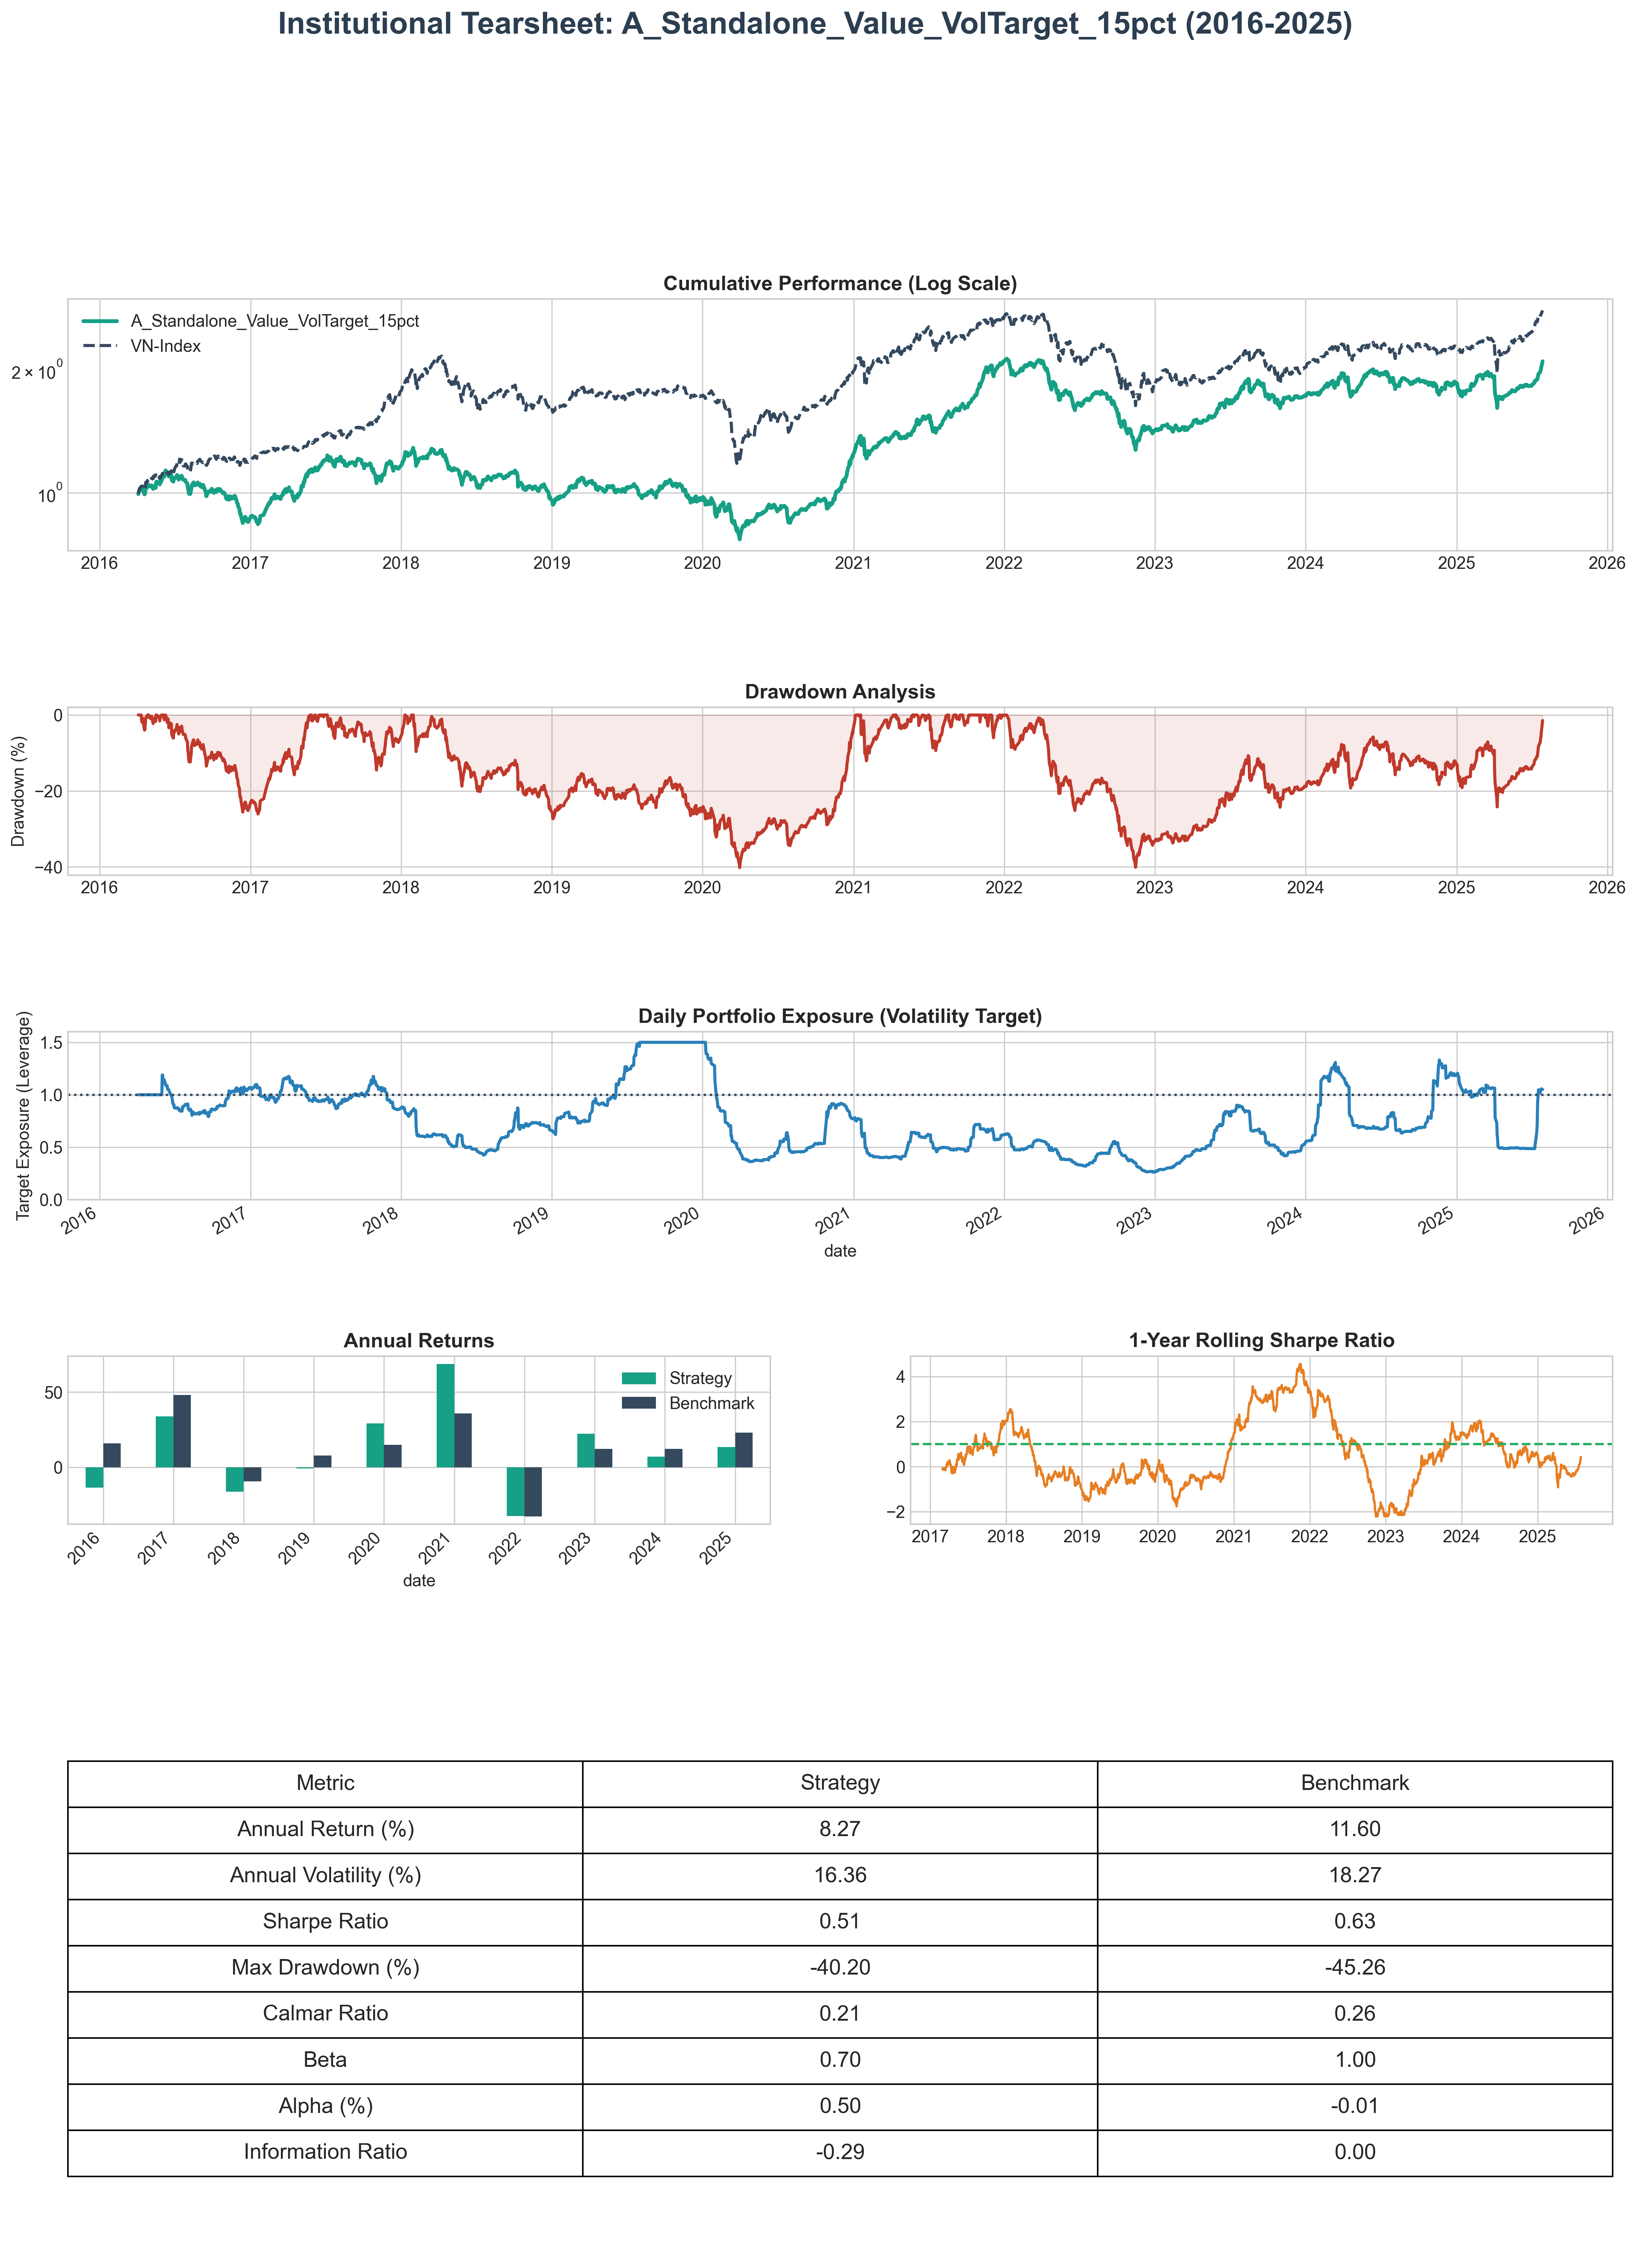

In [7]:
# ============================================================================
# EXECUTION: RUN STANDALONE VALUE WITH VOLATILITY TARGETING
# ============================================================================

# --- 1. Define the Configuration for this Run ---
vol_target_config = {
    **ALL_CONFIGS['A_Standalone_Value'], # Start with our best baseline config
    "strategy_name": "A_Standalone_Value_VolTarget_15pct",
    "volatility_target": 0.15, # As specified in the assessment
    "volatility_lookback": 63  # Use a 3-month lookback for stability
}

print("⚙️  Configuration set for Volatility-Targeted backtest.")

# --- 2. Instantiate and Run the New Engine ---
vol_target_backtester = PortfolioEngine_v3_2(
    config=vol_target_config,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine,
    palette=PALETTE
)

vol_target_returns, daily_exposure = vol_target_backtester.run()

# --- 3. Generate the Enhanced Tearsheet ---
# (We need a new tearsheet function to handle the exposure plot)
def generate_enhanced_tearsheet(strategy_returns, daily_exposure, benchmark_returns, config, palette):
    metrics = vol_target_backtester._calculate_performance_metrics(strategy_returns)
    benchmark_metrics = vol_target_backtester._calculate_performance_metrics(benchmark_returns)
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod()
    benchmark_cum = (1 + benchmark_returns.loc[first_trade_date:]).cumprod()
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(6, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 0.8, 1.2], hspace=0.8, wspace=0.2)
    title = f"Institutional Tearsheet: {config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"
    fig.suptitle(title, fontsize=20, fontweight='bold', color=palette['text'])

    # Plot 1: Cumulative Performance
    ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=config['strategy_name'], color=palette['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=palette['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left')
    
    # Plot 2: Drawdown
    ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=palette['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=palette['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)')
    
    # Plot 3: Daily Exposure
    ax_exp = fig.add_subplot(gs[2, :]); daily_exposure.loc[first_trade_date:].plot(ax=ax_exp, color=palette['highlight_1'], linewidth=2); ax_exp.set_title('Daily Portfolio Exposure (Volatility Target)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure (Leverage)'); ax_exp.axhline(1.0, color=palette['secondary'], linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6)

    # Other plots
    ax3 = fig.add_subplot(gs[3, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[palette['primary'], palette['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold')
    ax4 = fig.add_subplot(gs[3, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=palette['highlight_2']); ax4.axhline(1.0, color=palette['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    
    # Table
    ax5 = fig.add_subplot(gs[4:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
    for key in metrics.keys(): summary_data.append([key, f"{metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("\n--- Generating Enhanced Tearsheet for Volatility-Targeted Strategy ---")
generate_enhanced_tearsheet(vol_target_returns, daily_exposure, benchmark_returns, vol_target_config, PALETTE)